<a href="https://colab.research.google.com/github/KimchiLim/algo-trading/blob/main/algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

# Fetch historical data for Apple Inc.
ticker = 'AAPL'
data = yf.download(ticker, start='2015-1-1', end='2018-1-1')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Display the first few rows of the dataset
print(data.head())

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2015-01-02  24.347170  27.332500  27.860001  26.837500  27.847500  212818400
2015-01-05  23.661272  26.562500  27.162500  26.352501  27.072500  257142000
2015-01-06  23.663504  26.565001  26.857500  26.157499  26.635000  263188400
2015-01-07  23.995316  26.937500  27.049999  26.674999  26.799999  160423600
2015-01-08  24.917273  27.972500  28.037500  27.174999  27.307501  237458000


Text(0, 0.5, 'Open Price')

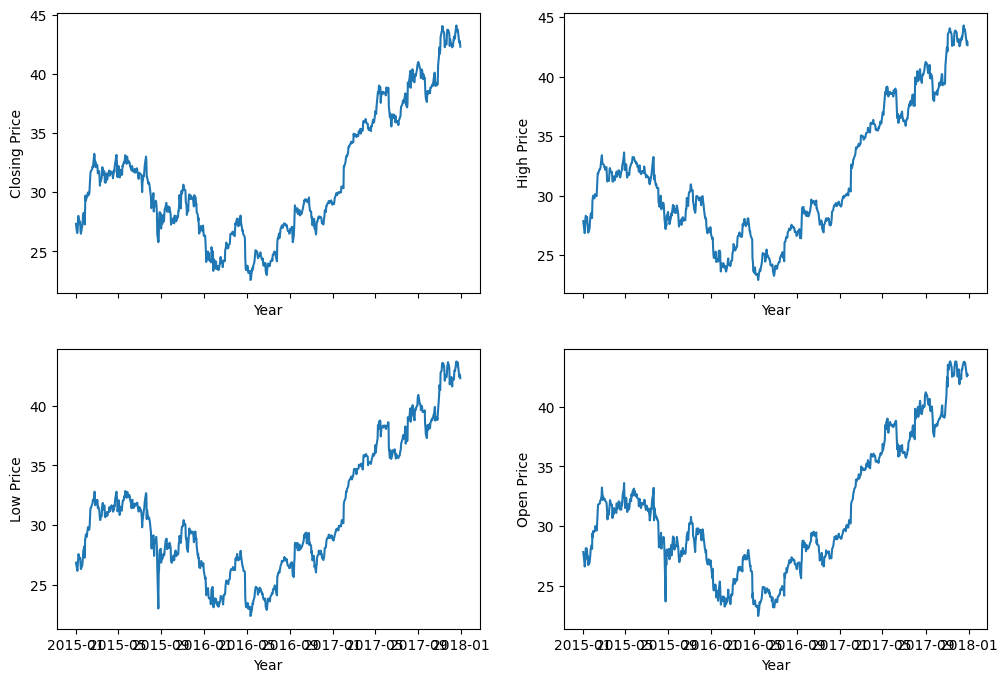

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(data['Close'])
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Closing Price')

axs[0, 1].plot(data['High'])
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('High Price')

axs[1, 0].plot(data['Low'])
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Low Price')

axs[1, 1].plot(data['Open'])
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Open Price')


In [ ]:
# Creating training and testing data for LSTM model
def load_data(stock, look_back, features, test_split=0.2):
  raw_data = stock[features].values
  data = []
  for i in range(len(raw_data) - look_back + 1):
    data.append(raw_data[i:i+look_back])

  data = np.array(data)

  test_size = int(len(data) * test_split)
  train_size = len(data) - test_size

  X_train = data[:train_size, :-1]
  y_train = data[:train_size, -1, :1]

  X_test = data[train_size:, :-1]
  y_test = data[train_size:, -1, :1]

  return [X_train, y_train, X_test, y_test]

In [ ]:
look_back = 30
features = ['Close', 'Open', 'High', 'Low']
X_train, y_train, X_test, y_test = load_data(data, look_back, features)

# Calculate the mean and standard deviation of each feature in the training set
X_mean = X_train.mean()
X_std = X_train.std()

# Standardize the training set
X_train = (X_train - X_mean) / X_std

# Standardize the test set using the mean and standard deviation of the training set
X_test = (X_test - X_mean) / X_std

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

X_train.size(), y_train.size()

(torch.Size([581, 29, 4]), torch.Size([581, 1]))

In [ ]:
# Build model
#####################
input_dim = len(features)
hidden_dim = 32
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.1)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 4])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t == 20:
      print(y_train_pred[:10])
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  14.788127899169922
tensor([[29.3812],
        [29.3812],
        [29.3812],
        [29.3812],
        [29.3812],
        [29.3812],
        [29.3812],
        [29.3812],
        [29.3812],
        [29.3812]], grad_fn=<SliceBackward0>)
Epoch  20 MSE:  14.238382339477539
Epoch  30 MSE:  14.30851936340332
Epoch  40 MSE:  14.22493839263916
Epoch  50 MSE:  14.232168197631836
Epoch  60 MSE:  14.226000785827637
Epoch  70 MSE:  14.223917007446289
Epoch  80 MSE:  14.22426986694336
Epoch  90 MSE:  14.223844528198242


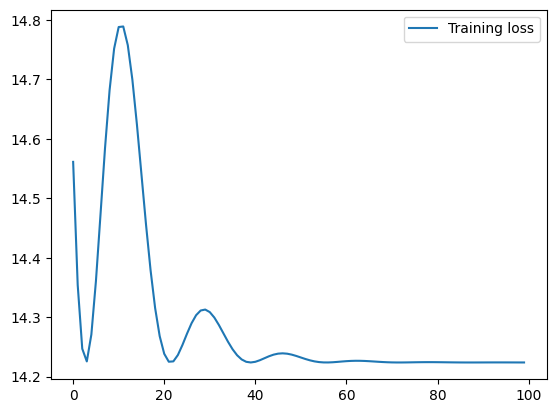

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
y_test_pred = model(X_test)
print(X_test)

tensor([[[2.0416, 1.9971, 2.0681, 1.9942],
         [1.9806, 2.0373, 2.0466, 1.9591],
         [1.9885, 1.9978, 2.0150, 1.9541],
         ...,
         [2.6622, 2.6615, 2.6730, 2.5933],
         [2.8251, 2.6909, 2.8251, 2.6414],
         [2.7160, 2.7454, 2.7533, 2.6823]],

        [[1.9806, 2.0373, 2.0466, 1.9591],
         [1.9885, 1.9978, 2.0150, 1.9541],
         [1.9784, 2.0100, 2.0251, 1.9512],
         ...,
         [2.8251, 2.6909, 2.8251, 2.6414],
         [2.7160, 2.7454, 2.7533, 2.6823],
         [2.7533, 2.7139, 2.8509, 2.7053]],

        [[1.9885, 1.9978, 2.0150, 1.9541],
         [1.9784, 2.0100, 2.0251, 1.9512],
         [2.1887, 2.0825, 2.2332, 2.0724],
         ...,
         [2.7160, 2.7454, 2.7533, 2.6823],
         [2.7533, 2.7139, 2.8509, 2.7053],
         [2.8193, 2.7942, 2.8631, 2.7555]],

        ...,

        [[3.9652, 4.0871, 4.1187, 3.9537],
         [3.8030, 3.8669, 3.8920, 3.7528],
         [3.9480, 3.9537, 4.0032, 3.8906],
         ...,
         [4.2285, 4.1

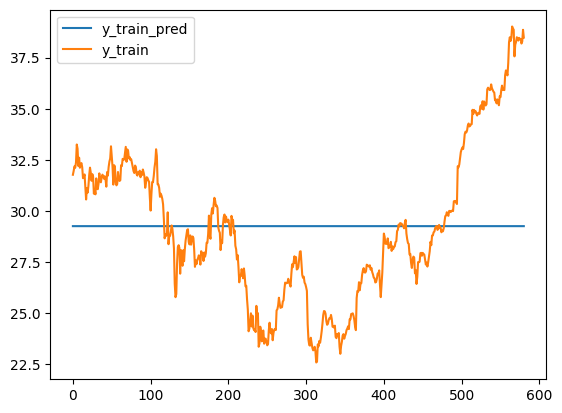

In [ ]:
plt.plot(y_train_pred.detach().numpy(), label="y_train_pred")
plt.plot(y_train, label="y_train")
plt.legend()
plt.show()

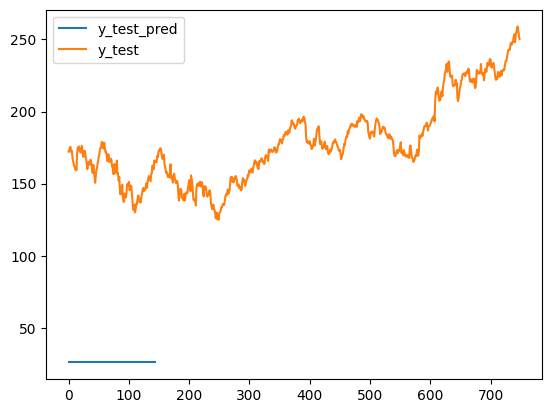

In [ ]:
plt.plot(y_test_pred.detach().numpy(), label="y_test_pred")
plt.plot(y_test, label="y_test")
plt.legend()
plt.show()